# Trading Strategies Based on Genetic Algorithms
## Learning sessions results analysis

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 8
%matplotlib inline

In [2]:
base_path = '/run/media/jjd/Win7/Users/jjd/Desktop/GAExperiment_2017-05-28_0211/'

### Fitness by Generations
The genetic algorithm ran for 32 generations. The session was ending after a  fitness stagnation for 9 generation.

The paper uses Sterling ratio as fitness:
$$SterlingRatio = \frac{NetProfit}{MaxDrawdown}$$

The Net Profit instead the Annualized return because the training period was of six months.

In order to avoid negative fitness issues, this study used:
$$fitness = 2^{SterlingRatio}$$

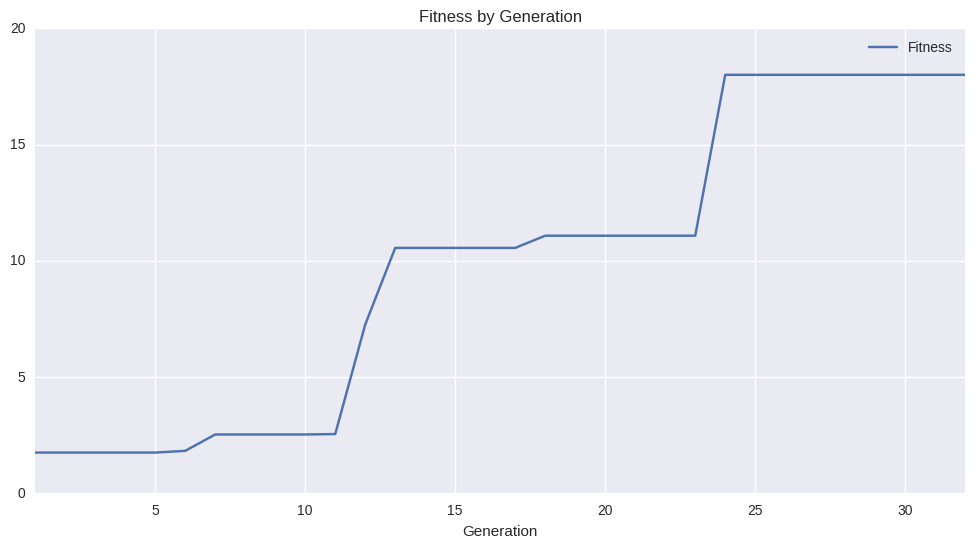

In [3]:
fitness_by_generation_file = base_path + 'FitnessByGeneration.csv' 
fitness_by_generation = pd.read_csv(fitness_by_generation_file)
fitness_by_generation.plot(x='Generation', y='Fitness', title='Fitness by Generation', figsize=(12,6));

The fitness shows a typical pattern in genetic algorithms, that is, many generations of fitness stagnation until a new innovation reaches new highs.

### Fitness by individuals

The number of individuals tested in the learning session was **1873**. 

In [4]:
# Read the data of all individual generated by the genetic algorithm and apply CamleCase format for the column names.
optimization_resutls = base_path + 'ResultsNoUnits.csv'
ga_results = pd.read_csv(optimization_resutls, )
camel_column_name = [n.replace(" ", "") for n in ga_results.columns]
ga_results.columns = camel_column_name

# The simple order in which the backtest results were saved will be used as individuals identification for further comparison.
ga_results['ID'] = ga_results.index

In [5]:
ga_results.shape[0]

1873

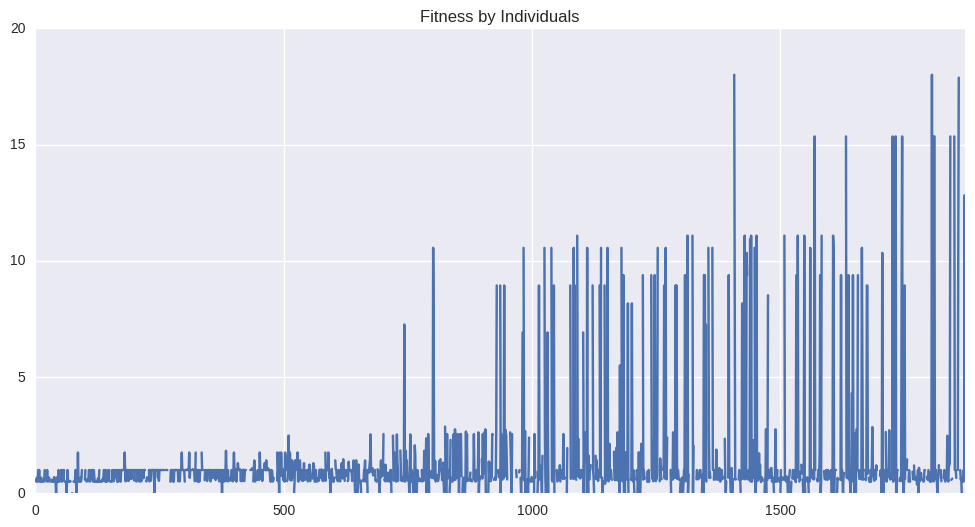

In [6]:
ga_results['SterlingRatio'] = ga_results.NetProfit / ga_results.Drawdown
ga_results['Fitness'] = 2 ** ga_results.SterlingRatio
ga_results.Fitness.plot(figsize=(12,6), title='Fitness by Individuals');

In [7]:
ga_results[ga_results.TotalTrades==0].shape[0]

249

In [8]:
ga_results[ga_results.Drawdown==0].shape[0]

456

In [9]:
ga_results[(ga_results.Drawdown==0) & (ga_results.TotalTrades==0)].shape[0]

249

In [10]:
ga_results[(ga_results.Drawdown==0) & (ga_results.TotalTrades!=0)].shape[0]

207

In [11]:
ga_results = ga_results[ga_results.Drawdown!=0]

The blanks in the plot corresponds to the 456 cases where the **`MaxDrawdown`** is equal to zero. 

From those cases 249 corresponds to cases where the agent was not able to generate signals (**`TotalTrades==0`**), the remaining 207 cases are consequence of some flaws in the experiment design and implementation.

First, the algorithm used to run the evaluations had a very low exposure. The reason for that decision was trying to keep the portfolio in positives values, even when many bad trades were made by the individuals (some individuals made more than 10000 trades!). *The problem with the low exposure is that the draw down is very small*. Second, the **`MaxDrawdown`** value is parsed from a string in percentage format with two decimals; thus, the small draw downs are rounded to zero. 

Another side-effect of this problem is that as the genetic algorithm only checks the fitness when considering the next generation, some of those individuals were completely ignored for the recombination, event when they had a good behavior (the best one has a Sharpe of 1.9).

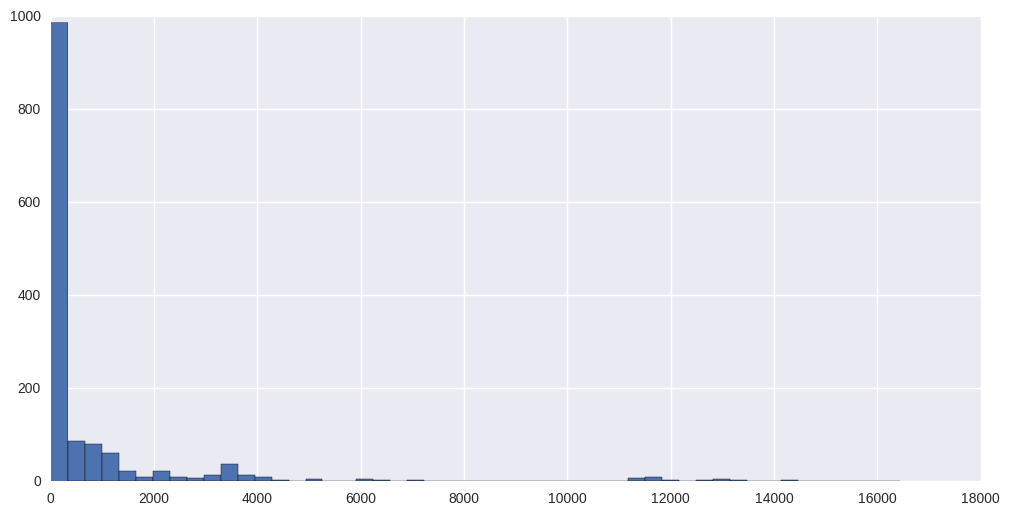

In [12]:
ga_results.TotalTrades.hist(bins=50, figsize=(12,6));

In [13]:
ga_results.TotalTrades.describe()

count     1417.000000
mean       840.293578
std       2195.199057
min          1.000000
25%          3.000000
50%         76.000000
75%        645.000000
max      16436.000000
Name: TotalTrades, dtype: float64

## In Sample vs Out of Sample

The training session period was 6 months from July 1st 2016 to December 31th 2016. The out sample period was January 2017.

Only the 40 individuals with Sterling ratio greater than one were considered to run the out of sample analysis.

In [25]:
out_of_sample_results = base_path + 'OutOfSampleBacktests/FullResutlsNoUnits.csv'
oos_results = pd.read_csv(out_of_sample_results)
oos_results['SterlingRatio'] = oos_results.NetProfit / oos_results.Drawdown

In [26]:
oos_vs_is = oos_results.join(ga_results, on='ID', how='inner', lsuffix='_OOS', rsuffix='_IS')

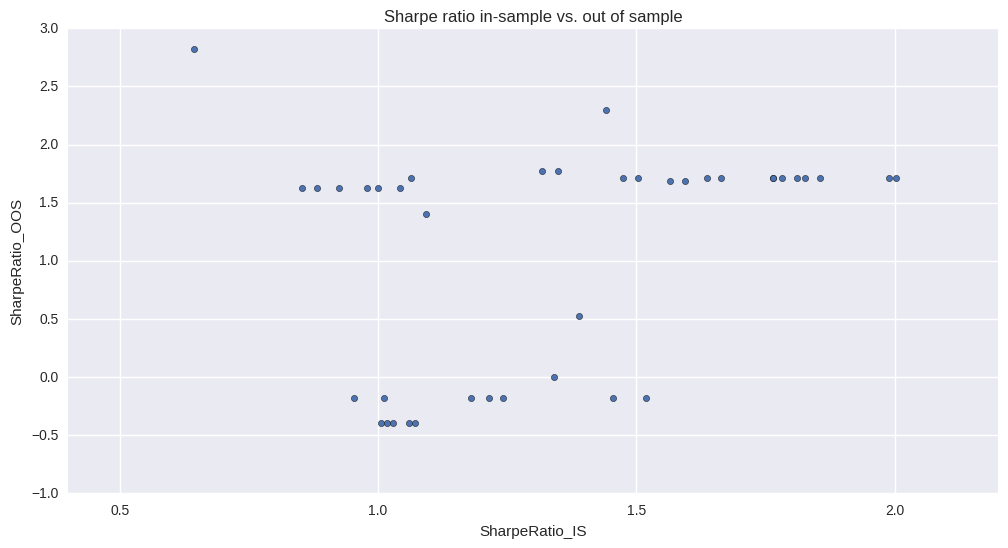

In [27]:
oos_vs_is.plot(kind='scatter', x='SharpeRatio_IS', y='SharpeRatio_OOS', figsize=(12,6),
               title='Sharpe ratio in-sample vs. out of sample');

In [31]:
oos_vs_is.SharpeRatio_OOS.describe()

count    40.000000
mean      1.067975
std       0.968266
min      -0.391000
25%      -0.177000
50%       1.623000
75%       1.710000
max       2.820000
Name: SharpeRatio_OOS, dtype: float64

## Conclusion

Even when the result are not correlated, worth notice that this was a genetic algorithm generating a set of technical indicator standard rules. 